1. Question: Load the NHANES dataset again and use the row index slicing as shown in examples to characterize the NHANES datset better. Now, find all the potential predictor variables that are suitable for: (a) linear regression (b) logistc regression (c) Poisson regression. Don’t forget to explain why they are suitable (will need to show proof such as looking at the levels or running some summary statistics).

In [3]:
# Import libraries.
import os
os.environ['LOKY_MAX_CPU_COUNT'] = '4'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression, PoissonRegressor
from sklearn.metrics import (
    mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, mean_poisson_deviance
)

# Set seed.
np.random.seed(328)
pd.set_option('display.max_columns', None)

# Load data.
NHANES = pd.read_csv('data/NHANES.csv')

# Inspect data.
print('NHANES shape:', NHANES.shape)
print('Rows:', NHANES.shape[0])
print('Columns:', NHANES.shape[1])
print('\nRow-sliced examples:')
display(NHANES.iloc[0:5, 0:8])
display(NHANES.iloc[250:255, [0, 1, 2, 3, 6, 8, 10, 11]])

NHANES shape: (10000, 75)
Rows: 10000
Columns: 75

Row-sliced examples:


,SurveyYr,ID,Gender,Age,AgeDecade,AgeMonths,Race1,Race3
0,2009_10,55829,female,28,20-29,343.0,White,NaN
1,2009_10,57112,male,14,10-19,170.0,White,NaN
2,2009_10,60232,male,80,NaN,NaN,White,NaN
3,2009_10,59919,male,22,20-29,268.0,White,NaN
4,2009_10,56351,male,1,0-9,16.0,White,NaN


,SurveyYr,ID,Gender,Age,Race1,Education,HHIncome,HHIncomeMid
250,2009_10,52471,female,46,Hispanic,SomeCollege,35000-44999,40000.0
251,2009_10,58855,male,37,Hispanic,9_11thGrade,NaN,NaN
252,2009_10,57872,female,25,Other,HighSchool,75000-99999,87500.0
253,2009_10,59286,male,3,White,NaN,more 99999,100000.0
254,2009_10,58834,female,80,White,HighSchool,more 99999,100000.0


In [4]:
# Build summary tables to justify variable suitability by model family.
num_cols = NHANES.select_dtypes(include='number').columns
obj_cols = NHANES.select_dtypes(exclude='number').columns
rows = []
for col in num_cols:
    s = NHANES[col].dropna().astype(float)
    if len(s) == 0:
        continue
    is_integer = bool(np.all(np.abs(s - np.round(s)) < 1e-9))
    rows.append({
        'column': col,
        'n_non_missing': int(len(s)),
        'pct_missing': float(100.0 * (1.0 - len(s) / len(NHANES))),
        'n_unique': int(s.nunique()),
        'min': float(s.min()),
        'max': float(s.max()),
        'mean': float(s.mean()),
        'std': float(s.std(ddof=1)),
        'is_integer_like': is_integer
    })
numeric_summary = pd.DataFrame(rows).set_index('column').sort_index()

# Binary columns (good logistic Y candidates after coding to 0/1).
binary_rows = []
for col in obj_cols:
    levels = sorted([str(v) for v in NHANES[col].dropna().unique().tolist()])
    if len(levels) == 2:
        binary_rows.append({
            'column': col,
            'levels': ', '.join(levels),
            'n_non_missing': int(NHANES[col].notna().sum()),
            'pct_missing': float(NHANES[col].isna().mean() * 100)
        })
binary_summary = pd.DataFrame(binary_rows).set_index('column').sort_index()

# Linear regression candidates (continuous numeric Y).
linear_candidates = numeric_summary[
    (numeric_summary['n_unique'] >= 20)
    & (numeric_summary['pct_missing'] <= 60)
    & (~numeric_summary['is_integer_like'])
].index.tolist()
linear_candidates = [c for c in linear_candidates if c != 'ID']

# Logistic regression candidates (binary Y with moderate missingness).
logistic_candidates = binary_summary[binary_summary['pct_missing'] <= 50].index.tolist()

# Poisson regression candidates (count-like Y columns in NHANES).
poisson_candidates = [
    'HomeRooms', 'DaysPhysHlthBad', 'DaysMentHlthBad',
    'nPregnancies', 'nBabies', 'PhysActiveDays',
    'AlcoholDay', 'AlcoholYear', 'SexNumPartnLife', 'SexNumPartYear'
]
poisson_candidates = [c for c in poisson_candidates if c in numeric_summary.index]
print('Linear regression (continuous numeric) candidates:', len(linear_candidates))
print(linear_candidates)
print('\nLogistic regression (binary) candidates:', len(logistic_candidates))
print(logistic_candidates)
print('\nPoisson regression (count) candidates:', len(poisson_candidates))
print(poisson_candidates)
print('\nNumeric summary for linear candidates:')
display(numeric_summary.loc[linear_candidates][['n_non_missing', 'pct_missing', 'n_unique', 'min', 'max', 'mean', 'std']])
print('Binary level summary for logistic candidates:')
display(binary_summary.loc[logistic_candidates])
print('Count summary for Poisson candidates:')
display(numeric_summary.loc[poisson_candidates][['n_non_missing', 'pct_missing', 'n_unique', 'min', 'max', 'mean', 'std']])

Linear regression (continuous numeric) candidates: 8
['BMI', 'DirectChol', 'Height', 'Poverty', 'Testosterone', 'TotChol', 'UrineFlow1', 'Weight']

Logistic regression (binary) candidates: 11
['Alcohol12PlusYr', 'Diabetes', 'Gender', 'HardDrugs', 'PhysActive', 'SameSex', 'SexEver', 'SleepTrouble', 'Smoke100', 'Smoke100n', 'SurveyYr']

Poisson regression (count) candidates: 10
['HomeRooms', 'DaysPhysHlthBad', 'DaysMentHlthBad', 'nPregnancies', 'nBabies', 'PhysActiveDays', 'AlcoholDay', 'AlcoholYear', 'SexNumPartnLife', 'SexNumPartYear']

Numeric summary for linear candidates:


,n_non_missing,pct_missing,n_unique,min,max,mean,std
column,,,,,,,
BMI,9634,3.66,2073,12.88,81.250,26.660136,7.376579
DirectChol,8474,15.26,106,0.39,4.030,1.364865,0.399258
Height,9647,3.53,980,83.60,200.400,161.877838,20.186567
Poverty,9274,7.26,450,0.00,5.000,2.801844,1.677909
Testosterone,4126,58.74,2311,0.25,1795.600,197.898000,226.504485
TotChol,8474,15.26,250,1.53,13.650,4.879220,1.075583
UrineFlow1,8397,16.03,2066,0.00,17.167,0.979295,0.949514
Weight,9922,0.78,1290,2.80,230.700,70.981798,29.125357


Binary level summary for logistic candidates:


,levels,n_non_missing,pct_missing
column,,,
Alcohol12PlusYr,"No, Yes",6580,34.20
Diabetes,"No, Yes",9858,1.42
Gender,"female, male",10000,0.00
HardDrugs,"No, Yes",5765,42.35
PhysActive,"No, Yes",8326,16.74
SameSex,"No, Yes",5768,42.32
SexEver,"No, Yes",5767,42.33
SleepTrouble,"No, Yes",7772,22.28
Smoke100,"No, Yes",7235,27.65


Count summary for Poisson candidates:


,n_non_missing,pct_missing,n_unique,min,max,mean,std
column,,,,,,,
HomeRooms,9931,0.69,13,1.0,13.0,6.248918,2.277538
DaysPhysHlthBad,7532,24.68,30,0.0,30.0,3.334838,7.400700
DaysMentHlthBad,7534,24.66,31,0.0,30.0,4.126493,7.832971
nPregnancies,2604,73.96,14,1.0,32.0,3.026882,1.795341
nBabies,2416,75.84,12,0.0,12.0,2.456954,1.315227
PhysActiveDays,4663,53.37,7,1.0,7.0,3.743513,1.836358
AlcoholDay,4914,50.86,25,1.0,82.0,2.914123,3.182672
AlcoholYear,5922,40.78,62,0.0,364.0,75.101655,103.033738
SexNumPartnLife,5725,42.75,90,0.0,2000.0,15.085066,57.846434


1. Answer: Using row slicing and summary tables, the NHANES dataset has 10,000 rows and 75 columns. Based on the value levels and numeric summaries, the linear regression suitable (continuous numeric Y candidates) set contains 8 columns that met the criteria (`n_unique >= 20`, missingness `<= 60%`, non-integer-like): `Poverty`, `Weight`, `Height`, `BMI`, `Testosterone`, `DirectChol`, `TotChol`, `UrineFlow1`. The logistic regression suitable (binary Y candidates) set contains 11 columns with exactly two levels and at most 50% missingness: `SurveyYr`, `Gender`, `Diabetes`, `SleepTrouble`, `PhysActive`, `Alcohol12PlusYr`, `Smoke100`, `Smoke100n`, `HardDrugs`, `SexEver`, `SameSex`. The Poisson regression suitable (count Y candidates) set contains 10 count-like variables: `HomeRooms`, `DaysPhysHlthBad`, `DaysMentHlthBad`, `nPregnancies`, `nBabies`, `PhysActiveDays`, `AlcoholDay`, `AlcoholYear`, `SexNumPartnLife`, `SexNumPartYear`. These are suitable because linear uses continuous responses, logistic uses binary outcomes (2 levels; not multinomial yet), and Poisson uses non-negative integer counts.

2. Question: For the subset of variables that will work with Linear Regression select a 3-4 of interest to use as predictors for the Y variable of your choice. Do pair-wise correlations for the X variables and then build a multiple linear regression model with interaction terms for any correlations over 0.25. Next, try to find a minimal form of X variables (1 or 2) and see if the predictive model is good.

Rows available for linear model: 8498
Pairwise correlations among X variables:


,Age,Weight,Height,Pulse
Age,1.000000,0.262237,0.159805,-0.231828
Weight,0.262237,1.000000,0.583976,-0.061209
Height,0.159805,0.583976,1.000000,-0.185465
Pulse,-0.231828,-0.061209,-0.185465,1.000000


Interaction terms added (|corr| > 0.25):
Age * Weight (corr=0.262)
Weight * Height (corr=0.584)


,model,test_MSE,test_R2
0,Full + interactions,0.112702,0.997751
1,Minimal (Weight only),9.381685,0.812783


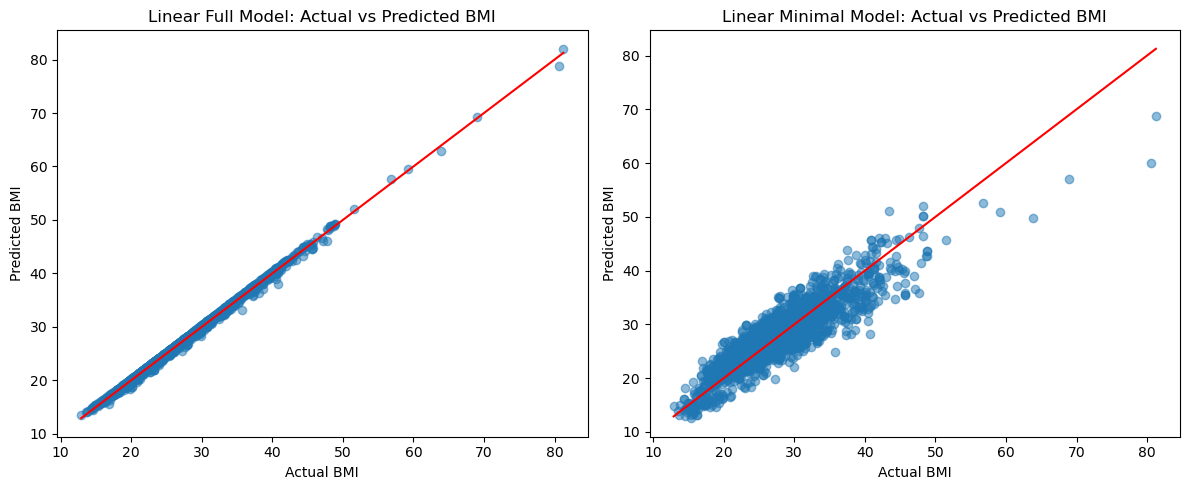

In [7]:
# Set up linear regression.
# Y choice: BMI
# X choice: Age, Weight, Height, Pulse
lin_y = 'BMI'
lin_x = ['Age', 'Weight', 'Height', 'Pulse']
lin_df = NHANES[[lin_y] + lin_x].dropna().copy()
print('Rows available for linear model:', len(lin_df))
lin_corr = lin_df[lin_x].corr(numeric_only=True)
print('Pairwise correlations among X variables:')
display(lin_corr)

# Add interactions for |corr| > 0.25.
lin_X_full = lin_df[lin_x].copy()
lin_interactions = []
for i in range(len(lin_x)):
    for j in range(i + 1, len(lin_x)):
        r = lin_corr.iloc[i, j]
        if abs(r) > 0.25:
            a, b = lin_x[i], lin_x[j]
            new_col = f'{a}_x_{b}'
            lin_X_full[new_col] = lin_X_full[a] * lin_X_full[b]
            lin_interactions.append((a, b, float(r)))
print('Interaction terms added (|corr| > 0.25):')
for a, b, r in lin_interactions:
    print(f'{a} * {b} (corr={r:.3f})')

# Train/test split (80/20).
X_train, X_test, y_train, y_test = train_test_split(
    lin_X_full, lin_df[lin_y], test_size=0.2, random_state=328
)
lin_full = LinearRegression().fit(X_train, y_train)
lin_full_pred = lin_full.predict(X_test)
lin_full_mse = mean_squared_error(y_test, lin_full_pred)
lin_full_r2 = r2_score(y_test, lin_full_pred)

# Minimal model (1 predictor): Weight
lin_x_min = ['Weight']
X_train_min, X_test_min, y_train_min, y_test_min = train_test_split(
    lin_df[lin_x_min], lin_df[lin_y], test_size=0.2, random_state=328
)
lin_min = LinearRegression().fit(X_train_min, y_train_min)
lin_min_pred = lin_min.predict(X_test_min)
lin_min_mse = mean_squared_error(y_test_min, lin_min_pred)
lin_min_r2 = r2_score(y_test_min, lin_min_pred)
metrics_linear = pd.DataFrame([
    {'model': 'Full + interactions', 'test_MSE': lin_full_mse, 'test_R2': lin_full_r2},
    {'model': 'Minimal (Weight only)', 'test_MSE': lin_min_mse, 'test_R2': lin_min_r2}
])
display(metrics_linear)

# Plot actual vs predicted.
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(y_test, lin_full_pred, alpha=0.5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red')
axes[0].set_title('Linear Full Model: Actual vs Predicted BMI')
axes[0].set_xlabel('Actual BMI')
axes[0].set_ylabel('Predicted BMI')
axes[1].scatter(y_test_min, lin_min_pred, alpha=0.5)
axes[1].plot([y_test_min.min(), y_test_min.max()], [y_test_min.min(), y_test_min.max()], color='red')
axes[1].set_title('Linear Minimal Model: Actual vs Predicted BMI')
axes[1].set_xlabel('Actual BMI')
axes[1].set_ylabel('Predicted BMI')
plt.tight_layout()
plt.show()

2. Answer: I used `BMI` as the response and predictors `Age`, `Weight`, `Height`, and `Pulse` (8,498 complete rows). The pairwise correlations above 0.25 were `Age` vs `Weight` = 0.262 and `Weight` vs `Height` = 0.584, so I added interaction terms `Age*Weight` and `Weight*Height` in the full model. On the test set, the full model + interactions had MSE = 0.1127 and R² = 0.9978, while the minimal model (Weight only) had MSE = 9.3817 and R² = 0.8128. The full model is extremely strong because BMI is mathematically tied to weight and height, and even the one-variable minimal model is still reasonably predictive.

3. Question: For the subset of variables select a 3-4 of interest to use as predictors for a suitable Y variable of your choice using logistic regression. Do pair-wise correlations for the X variables and then build a multiple logistic regression model with interaction terms for any correlations over 0.25. Next, try to find a minimal form of X variables (1 or 2) and see if the predictive model is good.

Rows available for logistic model: 7931
Positive rate (Diabetes=Yes): 0.08498297818686168
Pairwise correlations among X variables:


,Age,BMI,BPSysAve,TotChol
Age,1.000000,0.245726,0.506842,0.310715
BMI,0.245726,1.000000,0.244950,0.120213
BPSysAve,0.506842,0.244950,1.000000,0.217131
TotChol,0.310715,0.120213,0.217131,1.000000


Interaction terms added (|corr| > 0.25):
Age * BPSysAve (corr=0.507)
Age * TotChol (corr=0.311)


,model,threshold,accuracy,precision,recall,f1,auc,tn,fp,fn,tp
0,Full + interactions (threshold=0.50),0.50,0.919345,0.640000,0.118519,0.200000,0.812672,1443,9,119,16
1,Full + interactions (threshold=0.16),0.16,0.851922,0.296748,0.540741,0.383202,0.812672,1279,173,62,73
2,Minimal Age+BMI (threshold=0.50),0.50,0.920561,0.384615,0.033333,0.061350,0.834058,1768,8,145,5
3,Minimal Age+BMI (threshold=0.19),0.19,0.867601,0.290837,0.486667,0.364090,0.834058,1598,178,77,73


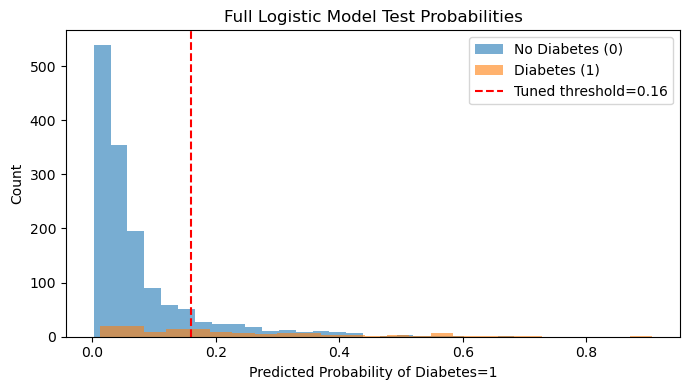

In [8]:
# Set up logistic regression.
# Y choice: Diabetes (Yes/No)
# X choice: Age, BMI, BPSysAve, TotChol
log_y = 'Diabetes'
log_x = ['Age', 'BMI', 'BPSysAve', 'TotChol']
log_df = NHANES[[log_y] + log_x].dropna().copy()
log_df['Diabetes_num'] = log_df['Diabetes'].map({'No': 0, 'Yes': 1})
print('Rows available for logistic model:', len(log_df))
print('Positive rate (Diabetes=Yes):', log_df['Diabetes_num'].mean())
log_corr = log_df[log_x].corr(numeric_only=True)
print('Pairwise correlations among X variables:')
display(log_corr)

# Add interactions for |corr| > 0.25.
log_X_full = log_df[log_x].copy()
log_interactions = []
for i in range(len(log_x)):
    for j in range(i + 1, len(log_x)):
        r = log_corr.iloc[i, j]
        if abs(r) > 0.25:
            a, b = log_x[i], log_x[j]
            new_col = f'{a}_x_{b}'
            log_X_full[new_col] = log_X_full[a] * log_X_full[b]
            log_interactions.append((a, b, float(r)))
print('Interaction terms added (|corr| > 0.25):')
for a, b, r in log_interactions:
    print(f'{a} * {b} (corr={r:.3f})')

# Define helpers.
def evaluate_logistic(y_true, prob, threshold):
    pred = (prob >= threshold).astype(int)
    return {
        'threshold': float(threshold),
        'accuracy': float(accuracy_score(y_true, pred)),
        'precision': float(precision_score(y_true, pred, zero_division=0)),
        'recall': float(recall_score(y_true, pred, zero_division=0)),
        'f1': float(f1_score(y_true, pred, zero_division=0)),
        'tn': int(confusion_matrix(y_true, pred)[0, 0]),
        'fp': int(confusion_matrix(y_true, pred)[0, 1]),
        'fn': int(confusion_matrix(y_true, pred)[1, 0]),
        'tp': int(confusion_matrix(y_true, pred)[1, 1])
    }

def best_threshold_by_f1(y_true, prob):
    grid = np.linspace(0.05, 0.50, 46)
    best_t = 0.50
    best_f1 = -1.0
    for t in grid:
        f1 = f1_score(y_true, (prob >= t).astype(int), zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_t = t
    return float(best_t)


# Train/test split (80/20).
X_train, X_test, y_train, y_test = train_test_split(
    log_X_full,
    log_df['Diabetes_num'].astype(int),
    test_size=0.2,
    random_state=328,
    stratify=log_df['Diabetes_num'].astype(int)
)
log_full = LogisticRegression(solver='liblinear', max_iter=3000).fit(X_train, y_train)
proba_train = log_full.predict_proba(X_train)[:, 1]
proba_test = log_full.predict_proba(X_test)[:, 1]
best_t_full = best_threshold_by_f1(y_train, proba_train)
auc_full = roc_auc_score(y_test, proba_test)
full_default = evaluate_logistic(y_test, proba_test, 0.50)
full_tuned = evaluate_logistic(y_test, proba_test, best_t_full)
full_default['model'] = 'Full + interactions (threshold=0.50)'
full_default['auc'] = float(auc_full)
full_tuned['model'] = f'Full + interactions (threshold={best_t_full:.2f})'
full_tuned['auc'] = float(auc_full)

# Minimal model (2 predictors): Age + BMI
log_x_min = ['Age', 'BMI']
log_df_min = NHANES[['Diabetes'] + log_x_min].dropna().copy()
log_df_min['Diabetes_num'] = log_df_min['Diabetes'].map({'No': 0, 'Yes': 1})
X_train_min, X_test_min, y_train_min, y_test_min = train_test_split(
    log_df_min[log_x_min],
    log_df_min['Diabetes_num'].astype(int),
    test_size=0.2,
    random_state=328,
    stratify=log_df_min['Diabetes_num'].astype(int)
)
log_min = LogisticRegression(solver='liblinear', max_iter=3000).fit(X_train_min, y_train_min)
proba_train_min = log_min.predict_proba(X_train_min)[:, 1]
proba_test_min = log_min.predict_proba(X_test_min)[:, 1]
best_t_min = best_threshold_by_f1(y_train_min, proba_train_min)
auc_min = roc_auc_score(y_test_min, proba_test_min)
min_default = evaluate_logistic(y_test_min, proba_test_min, 0.50)
min_tuned = evaluate_logistic(y_test_min, proba_test_min, best_t_min)
min_default['model'] = 'Minimal Age+BMI (threshold=0.50)'
min_default['auc'] = float(auc_min)
min_tuned['model'] = f'Minimal Age+BMI (threshold={best_t_min:.2f})'
min_tuned['auc'] = float(auc_min)
metrics_logistic = pd.DataFrame([full_default, full_tuned, min_default, min_tuned])[
    ['model', 'threshold', 'accuracy', 'precision', 'recall', 'f1', 'auc', 'tn', 'fp', 'fn', 'tp']
]
display(metrics_logistic)

# Probability plot (test set, full model).
plt.figure(figsize=(7, 4))
plt.hist(proba_test[y_test == 0], bins=25, alpha=0.6, label='No Diabetes (0)')
plt.hist(proba_test[y_test == 1], bins=25, alpha=0.6, label='Diabetes (1)')
plt.axvline(best_t_full, color='red', linestyle='--', label=f'Tuned threshold={best_t_full:.2f}')
plt.title('Full Logistic Model Test Probabilities')
plt.xlabel('Predicted Probability of Diabetes=1')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

3. Answer: I used `Diabetes` as the binary response with predictors `Age`, `BMI`, `BPSysAve`, and `TotChol` (7,931 complete rows). The correlations over 0.25 were `Age` vs `BPSysAve` = 0.507 and `Age` vs `TotChol` = 0.311, so I added interaction terms `Age*BPSysAve` and `Age*TotChol`. For the full model, AUC on the test set was 0.8127. At threshold 0.50, accuracy was high (0.9193) but recall was low (0.1185) due class imbalance. Using a threshold tuned on the training split (0.16) improved balance, where the full tuned model had accuracy 0.8519, precision 0.2967, recall 0.5407, F1 0.3832, and confusion matrix `[[1279, 173], [62, 73]]`. For the minimal model (`Age`, `BMI` only), AUC was 0.8341, and the tuned-threshold results (threshold 0.19) were accuracy 0.8676, precision 0.2908, recall 0.4867, F1 0.3641, and confusion matrix `[[1598, 178], [77, 73]]`. The minimal model is still reasonably good, but the full interaction model gives the best F1/recall tradeoff.

4. Question: For the subset of variables select a 3-4 of interest (X1, X2, X3... ) to use as predictors for a suitable Y variable of your choice using Poisson regression. Do pair-wise correlations for the X variables and then build a multiple logistic regression model with interaction terms for any correlations over 0.25. Next, try to find a minimal form of X variables (1 or 2) and see if the predictive model is good.

Rows available for Poisson model: 4886
AlcoholYear summary: mean= 90.46234138354482 var= 11395.28159075017 min= 1 max= 364
Pairwise correlations among X variables:


,Age,BMI,Weight,AlcoholDay
Age,1.000000,0.050981,0.006188,-0.250227
BMI,0.050981,1.000000,0.881320,0.028314
Weight,0.006188,0.881320,1.000000,0.096091
AlcoholDay,-0.250227,0.028314,0.096091,1.000000


Interaction terms added (|corr| > 0.25):
Age * AlcoholDay (corr=-0.250)
BMI * Weight (corr=0.881)


,model,test_mean_poisson_deviance,test_D2
0,Full + interactions,96.942290,0.134625
1,Minimal (Age + BMI),104.227699,0.069590


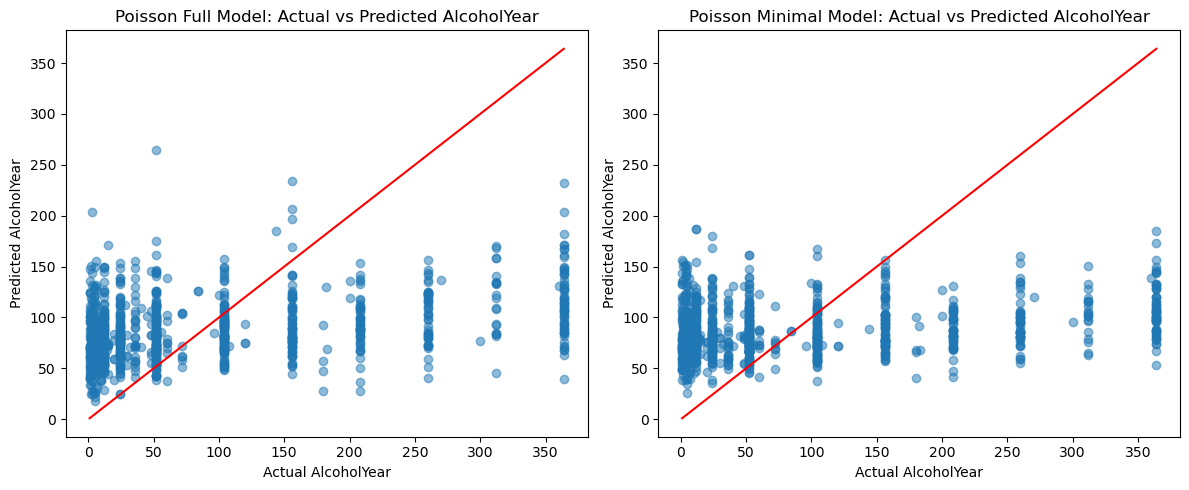

In [9]:
# Set up Poisson regression.
# Y choice: AlcoholYear (count of drinking days per year)
# X choice: Age, BMI, Weight, AlcoholDay
poi_y = 'AlcoholYear'
poi_x = ['Age', 'BMI', 'Weight', 'AlcoholDay']
poi_df = NHANES[[poi_y] + poi_x].dropna().copy()
poi_df[poi_y] = np.clip(np.round(poi_df[poi_y].astype(float)).astype(int), 0, None)
print('Rows available for Poisson model:', len(poi_df))
print('AlcoholYear summary: mean=', poi_df[poi_y].mean(), 'var=', poi_df[poi_y].var(ddof=1),
      'min=', poi_df[poi_y].min(), 'max=', poi_df[poi_y].max())
poi_corr = poi_df[poi_x].corr(numeric_only=True)
print('Pairwise correlations among X variables:')
display(poi_corr)

# Add interactions for |corr| > 0.25.
poi_X_full = poi_df[poi_x].copy()
poi_interactions = []
for i in range(len(poi_x)):
    for j in range(i + 1, len(poi_x)):
        r = poi_corr.iloc[i, j]
        if abs(r) > 0.25:
            a, b = poi_x[i], poi_x[j]
            new_col = f'{a}_x_{b}'
            poi_X_full[new_col] = poi_X_full[a] * poi_X_full[b]
            poi_interactions.append((a, b, float(r)))
print('Interaction terms added (|corr| > 0.25):')
for a, b, r in poi_interactions:
    print(f'{a} * {b} (corr={r:.3f})')

# Train/test split (80/20).
X_train, X_test, y_train, y_test = train_test_split(
    poi_X_full, poi_df[poi_y], test_size=0.2, random_state=328
)
poi_full = PoissonRegressor(alpha=0.0, max_iter=5000).fit(X_train, y_train)
poi_full_pred = np.clip(poi_full.predict(X_test), 1e-9, None)
poi_full_dev = mean_poisson_deviance(y_test, poi_full_pred)
poi_full_d2 = poi_full.score(X_test, y_test)

# Minimal model (2 predictors): Age + BMI
poi_x_min = ['Age', 'BMI']
X_train_min, X_test_min, y_train_min, y_test_min = train_test_split(
    poi_df[poi_x_min], poi_df[poi_y], test_size=0.2, random_state=328
)
poi_min = PoissonRegressor(alpha=0.0, max_iter=5000).fit(X_train_min, y_train_min)
poi_min_pred = np.clip(poi_min.predict(X_test_min), 1e-9, None)
poi_min_dev = mean_poisson_deviance(y_test_min, poi_min_pred)
poi_min_d2 = poi_min.score(X_test_min, y_test_min)
metrics_poisson = pd.DataFrame([
    {'model': 'Full + interactions', 'test_mean_poisson_deviance': poi_full_dev, 'test_D2': poi_full_d2},
    {'model': 'Minimal (Age + BMI)', 'test_mean_poisson_deviance': poi_min_dev, 'test_D2': poi_min_d2}
])
display(metrics_poisson)

# Plot actual vs predicted counts.
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(y_test, poi_full_pred, alpha=0.5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red')
axes[0].set_title('Poisson Full Model: Actual vs Predicted AlcoholYear')
axes[0].set_xlabel('Actual AlcoholYear')
axes[0].set_ylabel('Predicted AlcoholYear')
axes[1].scatter(y_test_min, poi_min_pred, alpha=0.5)
axes[1].plot([y_test_min.min(), y_test_min.max()], [y_test_min.min(), y_test_min.max()], color='red')
axes[1].set_title('Poisson Minimal Model: Actual vs Predicted AlcoholYear')
axes[1].set_xlabel('Actual AlcoholYear')
axes[1].set_ylabel('Predicted AlcoholYear')
plt.tight_layout()
plt.show()

4. Answer: I used `AlcoholYear` (count response) with predictors `Age`, `BMI`, `Weight`, and `AlcoholDay` (4,886 complete rows after dropping missing values). In this subset, `AlcoholYear` ranged from 1 to 364, with mean 90.4623 and variance 11,395.2816. The correlations over 0.25 were `Age` vs `AlcoholDay` = -0.250 and `BMI` vs `Weight` = 0.881, so I added interaction terms `Age*AlcoholDay` and `BMI*Weight`. On the test set, the full model + interactions had mean Poisson deviance = 96.9423 and D² = 0.1346, while the minimal model (Age + BMI) had mean Poisson deviance = 104.2277 and D² = 0.0696. The full model is better (lower deviance and higher D²), while the minimal model still captures a smaller amount of signal but loses predictive power.